In [21]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib as mpl
import numpy.ma as ma
from scipy import interpolate
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook

import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime 

In [22]:
def get_varbs(kind, case, fname, meshmaskname, dep_ind, time):
    
    # ------------------------------------------------
    
    if time == None:
        time_ind = slice(1,6*24,None)
    else:
        time_ind = time
        
    # ------------------------------------------------
        
    if kind == 'ideal':
        x_start = 132
        x_end = 202
    elif kind == 'real':
        x_start = 128
        x_end = 178
    y_start = 100
    y_end = 160
    
    # ------------------------------------------------
    
    dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
    
    filesU = general_functions.get_files(dirname, fname, 'grid_U')        
    filesV = general_functions.get_files(dirname, fname, 'grid_V')
    
    y,x = slice(y_start, y_end,None), slice(x_start, x_end,None)
    #y,x = slice(1, -1,None), slice(1, -1,None)
    
    with scDataset(filesU) as dsU, scDataset(filesV) as dsV:
        vozocrtx0 = dsU.variables['vozocrtx'][time_ind, dep_ind, y, x]
        vomecrty0 = dsV.variables['vomecrty'][time_ind, dep_ind, y, x]
        sozotaux = dsU.variables['sozotaux'][time_ind,0,0]
        
    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        umask0 = dsM.variables['umask'][0,dep_ind,y,x]
        vmask0 = dsM.variables['vmask'][0,dep_ind,y,x]
        
        e1t0 = np.nanmean(dsM.variables['e1t'][0, y, x], axis=0)
        e2t0 = np.nanmean(dsM.variables['e2t'][0, y, x], axis=1)
        e1t = np.cumsum(e1t0) / 1000 # km
        e2t = np.cumsum(e2t0) / 1000 # km
        e1v = dsM.variables['e1v'][0, y, x]
        e2u = dsM.variables['e2u'][0, y, x]
        gdept = dsM.variables['gdept_1d'][0, dep_ind]
    
    try:
        umask = np.tile(umask0, (len(sozotaux), 1, 1))
        vmask = np.tile(vmask0, (len(sozotaux), 1, 1))
    except TypeError:
        umask = umask0
        vmask = vmask0

    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
        
    return vozocrtx, vomecrty, e1t, e2t, e1v, e2u, gdept, umask

In [23]:
def get_vorticity(vozocrtx, vomecrty, e1v, e2u):
    
    u_daily = vozocrtx
    v_daily = vomecrty
    
    dV = np.diff(v_daily, axis=-1)
    dx = e1v[..., :-1]
    dVdx = dV/dx
    
    dU = np.diff(u_daily, axis=-2)
    dy = e2u[:-1, ...]
    dUdy = dU/dy

    zeta = dVdx[:-1, ...] - dUdy[..., :-1]
    
    return zeta

In [24]:
def get_separation_max(zeta, umask, e1t, e2t):

    x_separate_all = []

    for y_vort_ind in range(zeta.shape[-2]):

        y_vort = e2t[y_vort_ind]

        zeta_max = np.nanmax(zeta[y_vort_ind, :])
        x_vort_ind = np.where(zeta[y_vort_ind, :] == zeta_max)[0][0]
        x_vort = e1t[x_vort_ind]

        x_land_ind0 = np.where(umask[y_vort_ind, :]==0)[0]
        
        if len(x_land_ind0) != 0:
            x_land = e1t[x_land_ind0[0]]
        else:
            x_land = np.nan
        
        x_separate = x_land - x_vort
        x_separate_all.append(x_separate)

    x_separate_max = np.nanmax(x_separate_all) 
    
    return x_separate_max

In [25]:
def compare_separation(kind, cases, fname, meshmaskname, dep_ind, time):

    xs = []
    comparison_value_all = []

    for case, n in zip(cases, np.arange(len(cases))):
        print(kind, case)
        if case == 'half': x = 1
        elif case == 'base': x = 2
        elif case == 'baseAW': x = 2
        elif case == 'double': x = 3

        vozocrtx, vomecrty, e1t, e2t, e1v, e2u, gdept, umask = get_varbs(kind, case, fname, meshmaskname, dep_ind, time)
        
        zeta = np.full([vozocrtx.shape[-3], vozocrtx.shape[-2]-1, vozocrtx.shape[-1]-1], np.nan)
        x_separate_max0 = np.full([vozocrtx.shape[-3]], np.nan)
        #count_percent = np.full([vozocrtx.shape[-3]], np.nan)
        
        for t in range(vozocrtx.shape[-3]):
            zeta[t, :, :] = get_vorticity(vozocrtx[t, :, :], vomecrty[t, :, :], e1v, e2u)
            #count_positive = np.sum(zeta[t, :, :] >= 0)
            #count_water = np.sum(umask[t, :, :] == 1)
            #percentage = count_positive/count_water
            x_separate_max0[t] = get_separation_max(zeta[t, :, :], umask[t, :, :], e1t, e2t)
        
        #count_percent = np.nanmean(percentage)
        x_separate_max = np.nanmax(x_separate_max0)
        
        xs.append(x)
        comparison_value_all.append(x_separate_max)
        
    print(comparison_value_all)

    return xs, comparison_value_all, gdept

In [26]:
def plot_setup_start():
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,0.2])
    ax = plt.subplot(gs[0, 0])
    leg = plt.subplot(gs[0, 1]); leg.axis('off')
    return fig, ax

def plot_setup_end(fig, ax, fs_numb, fs_str):
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['half', 'base', 'double'])
    ax.grid(which='major', axis='both', linestyle='-')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(axis='both', which='both', length=0, labelsize=fs_numb)
    ax.set_ylabel('Separation [km]', fontsize=fs_str)
    ax.set_xlabel('Wind forcing cases', fontsize=fs_str)

    fig.tight_layout()
    fig.patch.set_facecolor('white')    
    plt.subplots_adjust(top=0.99, wspace=0.1, hspace=0.1)
    
    return fig, ax

# Map

# Final Comparison

In [31]:
fname = '1_MCKNZ_1h_20170101_201701*'
meshmaskname = '1_mesh_mask.nc'
kinds = ['real']#'ideal', 
cases = ['base']#'half', 'base', 'double']
dep_inds = np.arange(9, 20)#[9, 18]#, 18]#14
colors = ['#8BA2E8', '#4364C8', '#283C78']
markers = ['o', 'd', 's']
time = None

9 real
real base
[16.593702750022906]
10 real
real base
[15.839443651958192]
11 real
real base
[15.085184759788568]
12 real
real base
[14.330925626933144]
13 real
real base
[12.822407326786006]
14 real
real base
[12.822407508591567]
15 real
real base
[12.822407508591567]
16 real
real base
[13.576667058054358]
17 real
real base
[14.330926436915032]
18 real
real base
[15.085185825623523]
19 real
real base
[14.330926635957077]


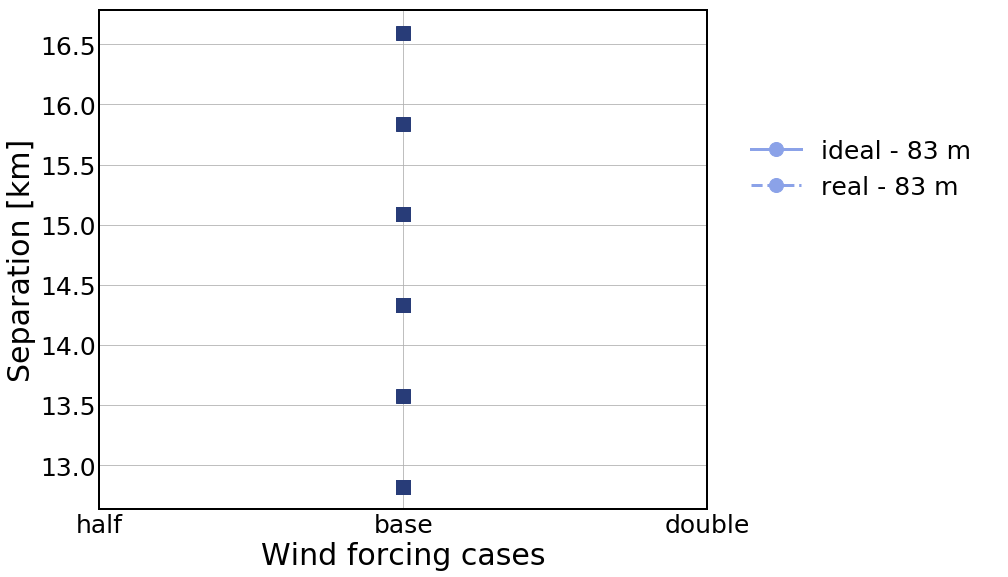

In [34]:
fs_numb, fs_str = 25, 30
fig, ax = plot_setup_start()
ls_all = []
for dep_ind, n in zip(dep_inds, np.arange(len(dep_inds))):#, colors, markers):
    for kind, ls in zip(kinds, ['-', '--']):
            print(dep_ind, kind)
            xs, sep, gdept = compare_separation(kind, cases, fname, meshmaskname, dep_ind, time)
            ls = ax.plot(xs, sep, lw=3, marker=m, ms=14, c=c, ls=ls, label=kind+' - '+str(int(round(gdept)))+' m')
            ls_all.append(ls)
# lns = ls_all[0]+ls_all[1]#+ls_all[2]+ls_all[3]#+ls_all[4]+ls_all[5]
# labels = [l.get_label() for l in lns]
leg = fig.legend(lns, labels, loc='upper right', bbox_to_anchor=(1.15, 0.8), fontsize=fs_numb, ncol=1, frameon=False)
fig, ax = plot_setup_end(fig, ax, fs_numb, fs_str)
figure_name = 'fig_comparison_separation.png'
fig.savefig(figure_name, dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())